In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
def isNaN(num):
    return num != num

In [3]:
merged_df = pd.read_csv('merged_with_isw.csv')

# Split data train/test

In [4]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

In [5]:
X = merged_df.drop(columns=['was_alarm'])
y_reg = merged_df['was_alarm']
y_bin = merged_df['was_alarm']

tscv = TimeSeriesSplit(n_splits=5)

## Decision Tree Classifier

In [6]:
merged_df.drop(columns='date', errors='ignore', inplace=True) 

In [7]:
print(merged_df.columns.to_list())

['advanc near', 'air defens', 'air forc', 'allow russian', 'alongsid static', 'area russian', 'arm armi', 'arm forc', 'armor vehicl', 'around bakhmut', 'assess russian', 'ballist missil', 'belgorod oblast', 'black sea', 'border area', 'campaign assess', 'chasiv yar', 'citi russian', 'claim russian', 'claim ukrainian', 'colonel gener', 'combin arm', 'conduct offens', 'continu effort', 'continu offens', 'counteroffens oper', 'critic russian', 'cruis missil', 'cutoff product', 'daili alongsid', 'data cutoff', 'defens industri', 'defens minist', 'defens mod', 'defens system', 'director gur', 'dnipro river', 'donetsk citi', 'donetsk oblast', 'drone strike', 'eastern ukrain', 'element th', 'financi yevgeni', 'footag publish', 'forc advanc', 'forc also', 'forc conduct', 'forc continu', 'forc launch', 'forc like', 'forc may', 'forc recent', 'forc reportedli', 'forc russian', 'forc struck', 'forc ukrain', 'forc use', 'foreign minist', 'fullscal invas', 'gener staff', 'geoloc footag', 'georg bar

In [8]:
X = merged_df.drop(columns=['was_alarm', 'day_datetime', 'hour_datetime'])
y = merged_df['was_alarm']
tscv = TimeSeriesSplit(n_splits=5)

model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=6,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n🔁 Fold {fold + 1}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

print("🔍 Classification report:")
print(classification_report(y_test, y_pred))


🔁 Fold 1

🔁 Fold 2

🔁 Fold 3

🔁 Fold 4

🔁 Fold 5
🔍 Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     80885
           1       1.00      0.97      0.98     27317

    accuracy                           0.99    108202
   macro avg       0.99      0.99      0.99    108202
weighted avg       0.99      0.99      0.99    108202



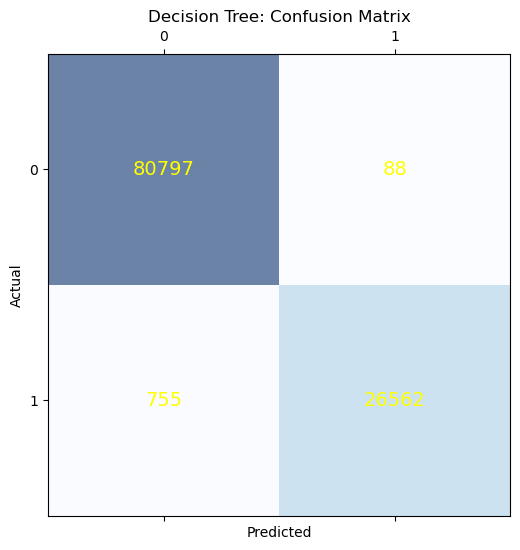

In [9]:
y_pred_last_bin = model.predict(X_test)
c_matrix = confusion_matrix(y_test, y_pred_last_bin)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(c_matrix, cmap='Blues', alpha=0.6)

for (i, j), val in np.ndenumerate(c_matrix):
    ax.text(j, i, val, ha='center', va='center', color='yellow', fontsize=14)

plt.title('Decision Tree: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


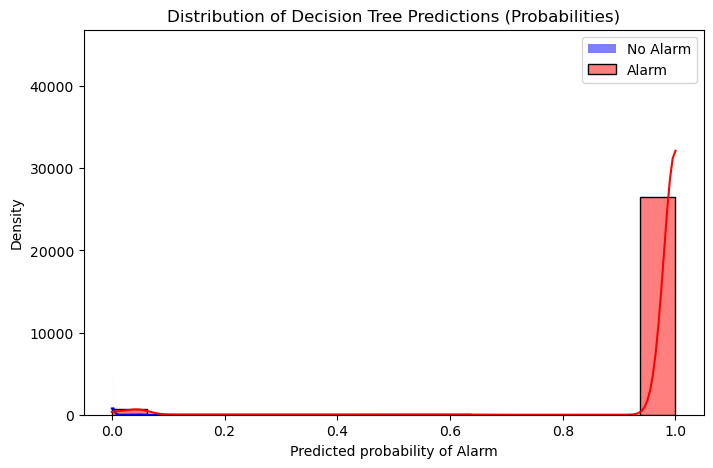

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_proba[y_test == 0], color='blue', label='No Alarm', kde=True)
sns.histplot(y_pred_proba[y_test == 1], color='red', label='Alarm', kde=True)
plt.title("Distribution of Decision Tree Predictions (Probabilities)")
plt.xlabel("Predicted probability of Alarm")
plt.ylabel("Density")
plt.legend()
plt.show()

                              feature    importance
228  other_regions_with_alarm_percent  9.978344e-01
227                         region_id  1.179416e-03
225               hour_solarradiation  3.189518e-04
200                 day_datetimeEpoch  1.447958e-04
212                hour_datetimeEpoch  1.215036e-04
209                    day_visibility  1.051957e-04
214                     hour_humidity  8.479029e-05
201                       day_tempmax  7.402356e-05
151                 russian territori  5.332934e-05
169                    strike russian  3.472396e-05
180                ukrainian children  2.842165e-05
210                   day_solarenergy  6.307324e-06
207                      day_pressure  5.928099e-06
6                            arm armi  5.293430e-06
206                     day_windspeed  8.438953e-07
67                        inform oper  7.734905e-07
113                       oper ukrain  5.804566e-07
171                   suggest russian  4.660340e-07
42          

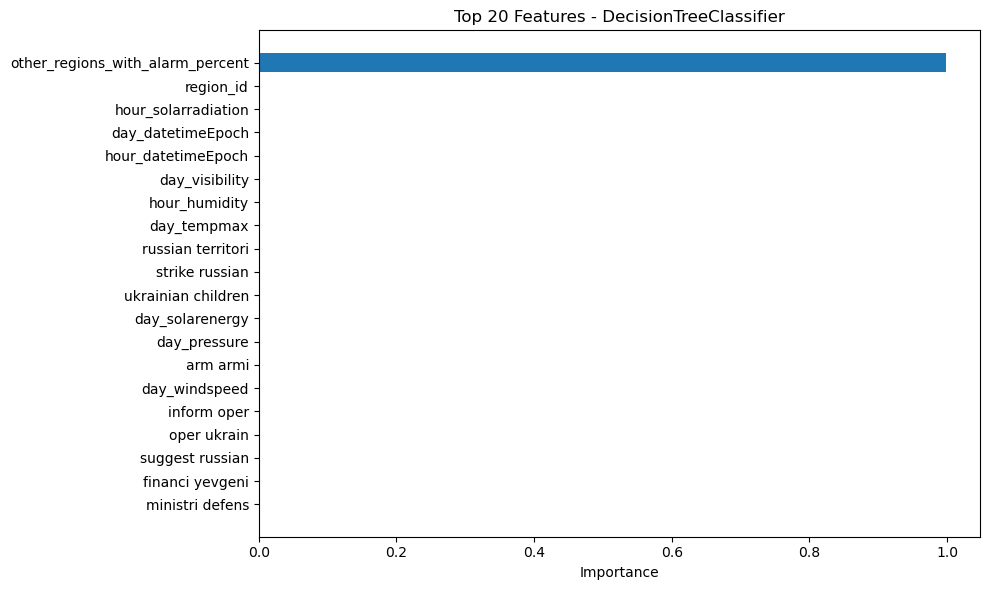

In [11]:
feature_names = X.columns
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
})

top_features = importances.sort_values(by='importance', ascending=False).head(20)
print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Features - DecisionTreeClassifier')
plt.tight_layout()
plt.show()

## after removal 'was_alarm', 'day_datetime', 'hour_datetime', 'other_regions_with_alarm_percent' + replacing hyperparameter value

In [12]:
X = merged_df.drop(columns=['was_alarm', 'day_datetime', 'hour_datetime', 'other_regions_with_alarm_percent'])
y = merged_df['was_alarm']

X = X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())

tscv = TimeSeriesSplit(n_splits=5)

model = DecisionTreeClassifier(
    criterion='entropy',        
    max_depth=18,               
    min_samples_split=6,        
    min_samples_leaf=2,          
    class_weight='balanced',  
    random_state=42
)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

print("🔍 Classification report:")
print(classification_report(y_test, y_pred))

🔍 Classification report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72     80885
           1       0.29      0.39      0.34     27317

    accuracy                           0.61    108202
   macro avg       0.53      0.54      0.53    108202
weighted avg       0.65      0.61      0.63    108202



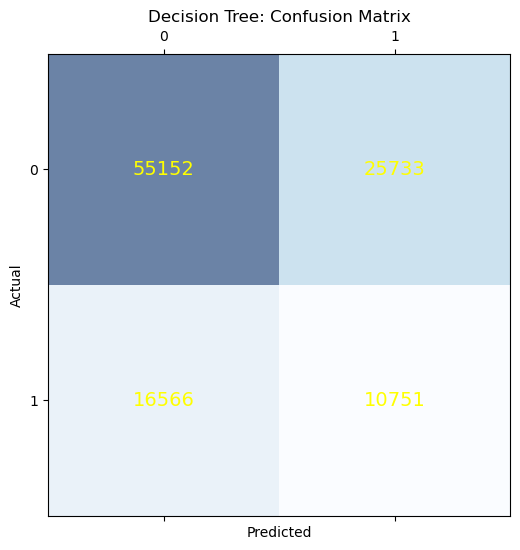

In [13]:
c_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(c_matrix, cmap='Blues', alpha=0.6)
for (i, j), val in np.ndenumerate(c_matrix):
    ax.text(j, i, val, ha='center', va='center', color='yellow', fontsize=14)
plt.title('Decision Tree: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


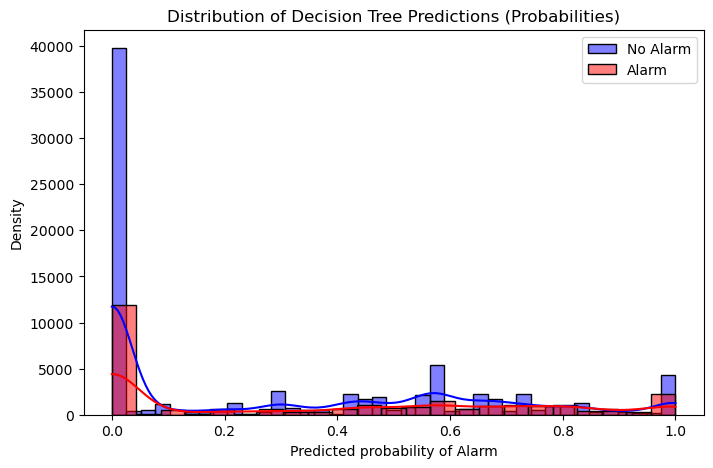

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(y_pred_proba[y_test == 0], color='blue', label='No Alarm', kde=True)
sns.histplot(y_pred_proba[y_test == 1], color='red', label='Alarm', kde=True)
plt.title("Distribution of Decision Tree Predictions (Probabilities)")
plt.xlabel("Predicted probability of Alarm")
plt.ylabel("Density")
plt.legend()
plt.show()


📌 Top 20 Features:
                 feature  importance
227            region_id    0.357868
212   hour_datetimeEpoch    0.122198
225  hour_solarradiation    0.042140
214        hour_humidity    0.034414
213            hour_temp    0.026186
219        hour_windgust    0.024188
221         hour_winddir    0.023318
222        hour_pressure    0.020794
215             hour_dew    0.016936
224      hour_cloudcover    0.012963
220       hour_windspeed    0.011709
27          cruis missil    0.009085
208       day_cloudcover    0.008658
209       day_visibility    0.007907
226     hour_solarenergy    0.007384
210      day_solarenergy    0.007296
48           forc launch    0.007115
204         day_humidity    0.006046
201          day_tempmax    0.005253
223      hour_visibility    0.004532


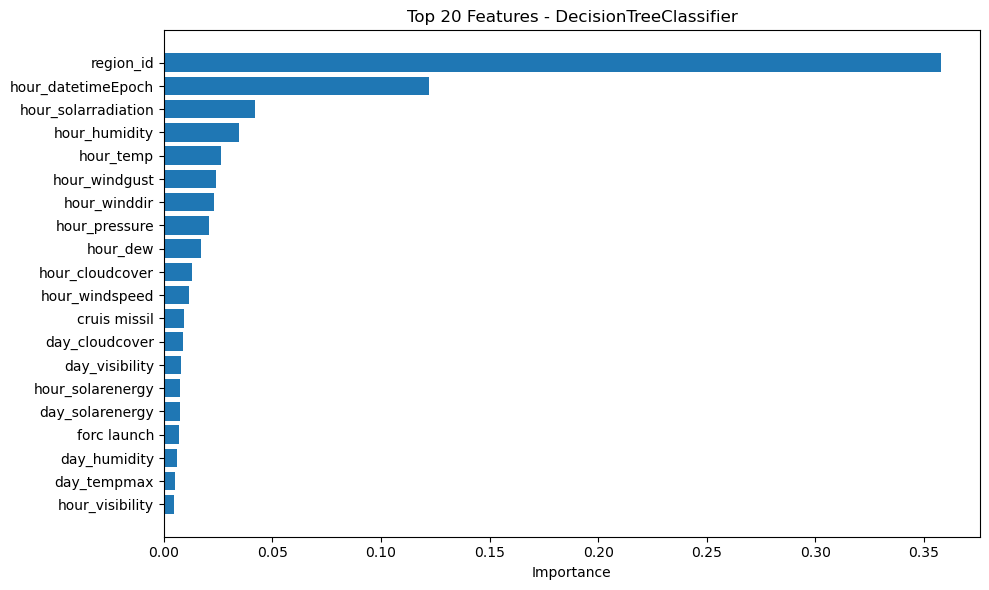

In [15]:
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})
top_features = importances.sort_values(by='importance', ascending=False).head(20)

print("\n📌 Top 20 Features:")
print(top_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 20 Features - DecisionTreeClassifier')
plt.tight_layout()
plt.show()

In [16]:
model_path = '/Users/dashazasko/Desktop/alarm_project/decision_tree_model.pkl'

In [17]:
with open(model_path, 'wb') as file:
    pickle.dump(model, file)